In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight

data = pd.read_csv('../data/preprocessed_data.csv')

data.head()
X = data.drop('Depression', axis=1)  
y = data['Depression']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Accuracy: 0.94


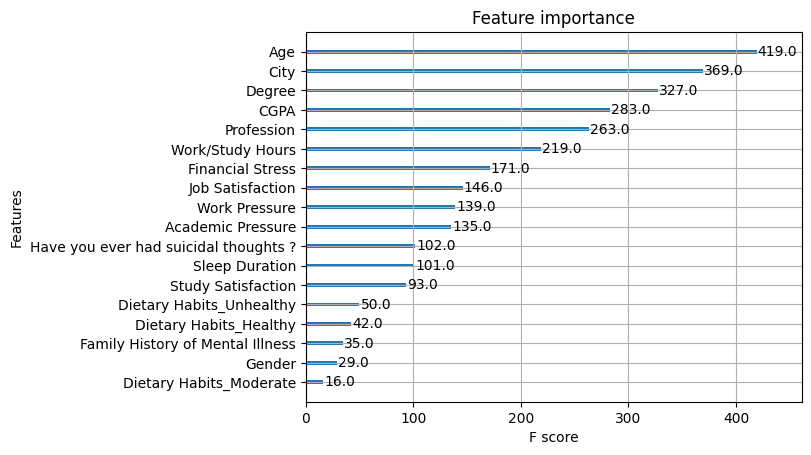

In [2]:
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "multi:softmax",  # Multiclass classification
    "num_class": 3,               # Number of classes
    "max_depth": 4,               # Maximum tree depth
    "eta": 0.3,                   # Learning rate
    "subsample": 0.8,             # Row sampling
    "colsample_bytree": 0.8       # Feature sampling
}

# Train the model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, train_dmatrix, num_rounds)


# Make predictions
y_pred = model.predict(test_dmatrix)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optional: Feature importance visualization
xgb.plot_importance(model)
import matplotlib.pyplot as plt
plt.show()

In [3]:
# Train a simple XGBoost model to get feature importance
model = xgb.XGBClassifier()
model.fit(X, y)

# Get feature importance
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Keep only features with importance above threshold (e.g., 0.01)
important_features = importance[importance['importance'] > 0.01]['feature'].tolist()

# Create new X with only important features
X = X[important_features]

# Now split the data with important features only
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Convert to one-hot encoded format
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [6]:
# # Feature engineering
def engineer_features(X):
    X_new = pd.DataFrame()
    X_new['X1'] = X.iloc[:, 0]  # First feature
    X_new['X2'] = X.iloc[:, 1]  # Second feature
    X_new['X12'] = X_new['X1'] ** 2
    X_new['X22'] = X_new['X2'] ** 2
    X_new['X1X2'] = X_new['X1'] * X_new['X2']
    X_new['sin_X1'] = np.sin(X_new['X1'])
    X_new['sin_X2'] = np.sin(X_new['X2'])
    return X_new

# Apply feature engineering
X_train_eng = engineer_features(X_train)
X_test_eng = engineer_features(X_test)

# Scale the engineered features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)




In [7]:
# Create model with specified architecture
model = models.Sequential([
    # Input layer
    layers.Dense(8, activation='leaky_relu', input_shape=(7,),
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    # First hidden layer
    layers.Dense(7, activation='leaky_relu',
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    # Second hidden layer
    layers.Dense(32, activation='relu', input_shape=(7,)),  # Try larger units (32, 64, 128)
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # Third hidden layer
    layers.Dense(5, activation='leaky_relu',
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    # Fourth hidden layer
    layers.Dense(4, activation='leaky_relu',
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.15),

    # Fifth hidden layer
    layers.Dense(3, activation='leaky_relu',
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.15),

    # Sixth hidden layer
    layers.Dense(4, activation='leaky_relu',
                kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-4),
                kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    
    # Output layer
    layers.Dense(2, activation='softmax')
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model = models.Sequential([
    # Input layer
    layers.Dense(64, activation='relu', input_shape=(7,),
                kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5),
                kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # First hidden layer
    layers.Dense(32, activation='relu',
                kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5),
                kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    # Second hidden layer
    layers.Dense(16, activation='relu',
                kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5),
                kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Third hidden layer
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.2),

    # Fourth hidden layer
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    
    # Output layer
    layers.Dense(y_train_encoded.shape[1], activation='softmax')
])

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,          # Increased patience to allow more exploration
    restore_best_weights=True,
    mode='min',
    min_delta=1e-4       # Minimum change to qualify as an improvement
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,          # More gradual learning rate reduction
    patience=10,         # Increased patience for learning rate reduction
    min_lr=1e-7,        # Lower minimum learning rate
    verbose=1,          # Print message when reducing LR
    mode='min',
    cooldown=5          # Wait 5 epochs after reducing LR before allowing another reduction
)

# Optional but recommended: Add ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Use all callbacks in model.fit()
callbacks = [early_stopping, reduce_lr, checkpoint]

In [24]:
# Compile with better optimizer settings
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.001,
    weight_decay=1e-4,
    beta_1=0.9,
    beta_2=0.999,
    amsgrad=True
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Changed from binary_crossentropy
    metrics=['accuracy', tf.keras.metrics.AUC()]
)



In [41]:
# Train with class weights matching your encoded labels
history = model.fit(
    X_train_scaled, y_train_encoded,  # Use encoded labels
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    class_weight={0: 1.0, 1: 1.5},
    verbose=1
)


# # Calculate weights based on original (non-encoded) labels
# weights = compute_class_weight('balanced', 
#                              classes=np.unique(y_train),
#                              y=y_train)

# # Create dictionary mapping
# class_weight = dict(enumerate(weights))


# history = model.fit(
#     X_train_scaled, y_train_encoded,
#     epochs=1000,
#     batch_size=512,
#     validation_split=0.2,
#     callbacks=[early_stopping, reduce_lr],
#     class_weight=class_weight,  # Use the calculated weights
#     verbose=1
# )

Epoch 1/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9067 - auc_2: 0.9644 - loss: 0.3023 - val_accuracy: 0.9019 - val_auc_2: 0.9669 - val_loss: 0.2374 - learning_rate: 6.2500e-05
Epoch 2/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9075 - auc_2: 0.9649 - loss: 0.2998 - val_accuracy: 0.9019 - val_auc_2: 0.9666 - val_loss: 0.2395 - learning_rate: 6.2500e-05
Epoch 3/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9056 - auc_2: 0.9639 - loss: 0.3038 - val_accuracy: 0.9019 - val_auc_2: 0.9666 - val_loss: 0.2378 - learning_rate: 6.2500e-05
Epoch 4/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9061 - auc_2: 0.9639 - loss: 0.3031 - val_accuracy: 0.9019 - val_auc_2: 0.9666 - val_loss: 0.2396 - learning_rate: 6.2500e-05
Epoch 5/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9081 - auc_2: 0.9649 - loss: 0.3001 - val_accuracy: 0.9019 - val_auc_2: 0.9657 - val_loss: 0.2411 - learning_rate: 6.2500e-05
Epoch 6/100
703/703 ━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [23]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded)
print(f'\nTest accuracy: {test_accuracy:.3f}')

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 2), output.shape=(None, 1)